## Datasets and Dataloaders
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data.

**Fashion-MNIST** 
- 28 pixels * 28 pixels
- gray scale 0-255
- 10 classes

In [7]:
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
import torch
import matplotlib.pyplot as plt
%matplotlib inline

training_data = datasets.FashionMNIST(
    root="data",  # root 是train/test存储的位置
    train=True,  # 表明是否是训练集   
    download=True, # download=True downloads the data from the internet if it’s not available at root.
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

每一条training_data是一个tuple，含有图片的tensor和label

In [3]:
print(training_data[0][0].shape)
print(f"label: {training_data[0][1]}")


torch.Size([1, 28, 28])
label: 9


In [26]:
batchsize= 64
# create data_loader
train_dataloader = DataLoader(training_data, batchsize, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batchsize, num_workers=4)

for X,y in test_dataloader:
    print(f"Shape of X [N,C,H,W]: {X.shape}")
    print(f"shape of y: {y.shape}, {y.dtype}")
    print(y)
    
    break    


Shape of X [N,C,H,W]: torch.Size([64, 1, 28, 28])
shape of y: torch.Size([64]), torch.int64
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])


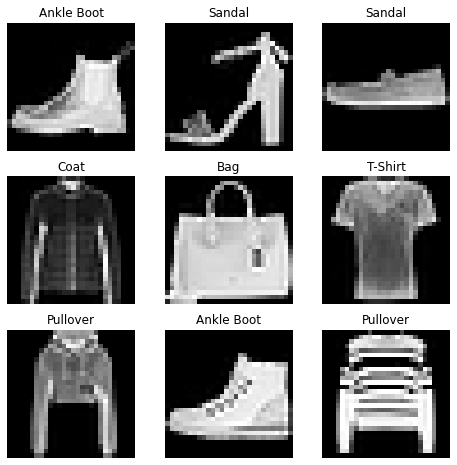

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## custom dataset for your project

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. Take a look at this implementation; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

The labels.csv file looks like:

> tshirt1.jpg, 0  
> tshirt2.jpg, 0  
> ......  
> ankleboot999.jpg, 9  


In [14]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):  
        """loads and returns a sample from the dataset at the given index idx."""
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.image_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Preparing your data for training with DataLoaders




In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")


using cpu device


In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(  # 各层的用法参考https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


更多loss function见nn module中 https://pytorch.org/docs/stable/nn.html#loss-functions

更多的optimizer见torch.optim https://pytorch.org/docs/stable/optim.html

In [24]:
loss_fn = nn.CrossEntropyLoss()  #交叉熵，用于分类问题，第一个参数是预测的softmax向量，第二个参数是真实的class label
#  更多loss function见nn module中 https://pytorch.org/docs/stable/nn.html#loss-functions
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # set model in train mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss:{loss:>7f} [{current:>5d}/{size:5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # set model in evaluation mode, This is equivalent with self.train(False).
    model.eval()
    testloss = 0
    correct = 0
    with torch.no_grad():
        """关于torch.no_grad()
        Context-manager that disabled gradient calculation.
        
        Disabling gradient calculation is useful for inference, 
        when you are sure that you will not call Tensor.backward(). 
        It will reduce memory consumption for computations that 
        would otherwise have requires_grad=True.
        
        see also https://pytorch.org/docs/stable/generated/torch.no_grad.html
        """ 
        for X,y in dataloader:
            X, y= X.to(device), y.to(device)
            pred= model(X)
            testloss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    testloss /= num_batches
    correct /= size
    print(f"test error: \n Accurancy {(100*correct):>0.1f}%, avg loss: {testloss:>8f}\n")    
    
    
    

In [25]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss:1.892647 [    0/60000]
loss:1.854672 [ 6400/60000]
loss:1.821297 [12800/60000]
loss:1.807996 [19200/60000]
loss:1.764158 [25600/60000]
loss:1.648861 [32000/60000]
loss:1.751082 [38400/60000]
loss:1.647121 [44800/60000]
loss:1.616072 [51200/60000]
loss:1.527769 [57600/60000]
test error: 
 Accurancy 60.0%, avg loss: 1.561323

Epoch 2
-------------------------------
loss:1.484269 [    0/60000]
loss:1.605566 [ 6400/60000]
loss:1.392220 [12800/60000]
loss:1.410773 [19200/60000]
loss:1.367193 [25600/60000]
loss:1.509480 [32000/60000]
loss:1.346368 [38400/60000]
loss:1.395230 [44800/60000]
loss:1.408124 [51200/60000]
loss:1.422628 [57600/60000]
test error: 
 Accurancy 62.8%, avg loss: 1.283337

Epoch 3
-------------------------------
loss:1.302583 [    0/60000]
loss:1.367890 [ 6400/60000]
loss:1.244787 [12800/60000]
loss:1.326634 [19200/60000]
loss:1.236747 [25600/60000]
loss:1.149018 [32000/60000]
loss:0.988895 [38400/60000]
loss:1.153650 [44800/6

## save &load models


In [27]:
torch.save(model.state_dict(), "model.pth")  # 这样会存储在当前文件目录下
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


To load model weights, you need to create an instance of the same model first, and then load the parameters using `load_state_dict()` method.

In [28]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))


classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## Saving and Loading Models with Shapes

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass `model` (and not `model.state_dict()`) to the saving function:

## Optimizing the model paramet|ers

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
